# Project: Basic MLOps


การ Deploy ระบบจำแนกรูปภาพด้วย Deep Learning ใน Azure Container Instances (ACI) ผ่าน API  
โดยใช้แหล่งข้อมูลหลักจาก https://share.traffy.in.th/teamchadchart และแหล่งข้อมูลเพิ่มเติมจากการค้นหารูปภาพทาง internet  
### สมาชิกในกลุ่ม
1. ณัฐจิรา จมูศรี รหัสนักศึกษา 6209656112
2. ศุกลภัทร ชิณวงศ์ รหัสนักศึกษา 6209656203
3. วิมลฉัตร อาภาสุขเจริญ รหัสนักศึกษา 6209656344
4. ชนัญญา เพชรน้อย รหัสนักศึกษา 6209656401

Image Classification คือ กระบวนการที่จำแนกรูปภาพออกเป็น Class เพื่อจำแนกรูปภาพ 5 ประเภท ได้แก่ ประเภทน้ำท่วม ประเภทการจราจร ประเภททางเท้า ประเภทความปลอดภัย และประเภทขยะ 

### กระบวนการดำเนินงาน
1. ติดตั้ง Package และนำเข้า Library  
2. นำเข้าข้อมูล  
3. การคัดเลือกและทำความสะอาดข้อมูล  
4. ตรวจสอบข้อมูลและดาวน์โหลดรูปภาพในแต่ละ class เพิ่ม  
5. นำเข้าข้อมูลที่จะใช้ในการเข้าโมเดล  
6. Convolutional Neural Network (CNN) และ CNN with augmentation
7. MoBileNetV2  
8. Random Forest
9. การ save model เพื่อนำไปใช้ในการ deployed
* หมายเหตุ: โดยในแต่ละโมเดลจะมีการพูดถึงการ evaluate ,การ prediction, และการทดสอบโมเดล

### 1) ติดตั้ง Package และนำเข้า Library

In [43]:
import pandas as pd
import urllib.request
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import imagehash
import glob
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
import pathlib
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import joblib

### 2) นำเข้าข้อมูล

2.1) นำเข้าไฟล์ CSV ที่ได้ดาวน์โหลดมาจาก teamchadchart

In [2]:
teamchadchart = pd.read_csv(r"C:\Users\Admin\Desktop\teamchadchart.csv",encoding="utf-8")
teamchadchart.head(3) #โหลดไฟล์ csv เข้า

type   organization                                            comment  \
0  ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
1  ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
2    อื่นๆ  เพื่อนชัชชาติ   อยากให้แก้ปัญหาเด็กเช็ดกระจกรถตามสี่แยกไฟแดงครับ   

                                coords  \
0  [100.559517592192,13.7700838665743]   
1  [100.559512898326,13.7700848434939]   
2  [100.560608720147,13.7369425530193]   

                                               photo  \
0  https://storage.googleapis.com/traffy_public_b...   
1  https://storage.googleapis.com/traffy_public_b...   
2  https://storage.googleapis.com/traffy_public_b...   

                                             address district   subdistrict  \
0  ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง        ดินแดง   
1  ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง        ดินแดง   
2  111 ชั้น 1 ถ. สุขุมวิท แขวง คลองเตย เขตคลองเตย...    วัฒนา  คลองเตยเหนือ   

        province                      timestamp  
0  กรุงเทพมหานคร   2022-03-17 14:12:52.56103+00  
1  กรุงเทพมหานคร  2022-03-17 13:44:37.242707+00  
2  กรุงเทพมหานคร  2022-03-17 11:46:14.841681+00

### 3) การคัดเลือกและทำความสะอาดข้อมูล

3.1) เรียกดูประเภทของ class ทั้งหมดที่มี

In [3]:
teamchadchart['type'].unique() #ดู class ทั้งหมดที่มี

array(['ทางเท้า', 'อื่นๆ', 'จราจร', 'ขยะ', 'ความปลอดภัย', 'น้ำท่วม',
       'เสนอแนะ'], dtype=object)

3.2) สร้าง dataframe ใหม่ที่ไม่มี class อื่น ๆ และ class แนะนำ

In [4]:
df = teamchadchart[(teamchadchart.type != 'อื่นๆ') & (teamchadchart.type != 'เสนอแนะ')] 
df.head(3)

type   organization                                            comment  \
0  ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
1  ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
5  ทางเท้า  เพื่อนชัชชาติ  สวัสดีครับ ขอแจ้งเรื่องร้องทุกข์ชาวบ้านเดือนร้...   

                                coords  \
0  [100.559517592192,13.7700838665743]   
1  [100.559512898326,13.7700848434939]   
5               [100.474905,13.712991]   

                                               photo  \
0  https://storage.googleapis.com/traffy_public_b...   
1  https://storage.googleapis.com/traffy_public_b...   
5  https://storage.googleapis.com/traffy_public_b...   

                                             address district subdistrict  \
0  ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
1  ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
5  789 ถนน ราชพฤกษ์ แขวง ตลาดพลู เขตธนบุรี กรุงเท...   จอมทอง      บางค้อ   

        province                      timestamp  
0  กรุงเทพมหานคร   2022-03-17 14:12:52.56103+00  
1  กรุงเทพมหานคร  2022-03-17 13:44:37.242707+00  
5  กรุงเทพมหานคร  2022-03-15 13:36:10.447933+00

3.3) ทำการ reset index ใหม่

In [5]:
df2 = df.reset_index(drop=True)
df2.head(3)

type   organization                                            comment  \
0  ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
1  ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
2  ทางเท้า  เพื่อนชัชชาติ  สวัสดีครับ ขอแจ้งเรื่องร้องทุกข์ชาวบ้านเดือนร้...   

                                coords  \
0  [100.559517592192,13.7700838665743]   
1  [100.559512898326,13.7700848434939]   
2               [100.474905,13.712991]   

                                               photo  \
0  https://storage.googleapis.com/traffy_public_b...   
1  https://storage.googleapis.com/traffy_public_b...   
2  https://storage.googleapis.com/traffy_public_b...   

                                             address district subdistrict  \
0  ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
1  ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
2  789 ถนน ราชพฤกษ์ แขวง ตลาดพลู เขตธนบุรี กรุงเท...   จอมทอง      บางค้อ   

        province                      timestamp  
0  กรุงเทพมหานคร   2022-03-17 14:12:52.56103+00  
1  กรุงเทพมหานคร  2022-03-17 13:44:37.242707+00  
2  กรุงเทพมหานคร  2022-03-15 13:36:10.447933+00

3.4) หาค่า hash ของแต่ละรูปภาพแล้วทำการเพิ่มค่า hash ลงในอีก column 
- โดยทำการ hash เพื่อต้องการจัดการรูปภาพที่ซ้ำกัน

In [6]:
otherhash = []
for i in range(df2.shape[0]):
    response_hash = requests.get(df2.photo[i])
    avg_hash = imagehash.average_hash(Image.open(BytesIO(response_hash.content)))
    otherhash.append(avg_hash)
df2["hash"] = otherhash 

In [7]:
df2.head(3)

type   organization                                            comment  \
0  ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
1  ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
2  ทางเท้า  เพื่อนชัชชาติ  สวัสดีครับ ขอแจ้งเรื่องร้องทุกข์ชาวบ้านเดือนร้...   

                                coords  \
0  [100.559517592192,13.7700838665743]   
1  [100.559512898326,13.7700848434939]   
2               [100.474905,13.712991]   

                                               photo  \
0  https://storage.googleapis.com/traffy_public_b...   
1  https://storage.googleapis.com/traffy_public_b...   
2  https://storage.googleapis.com/traffy_public_b...   

                                             address district subdistrict  \
0  ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
1  ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
2  789 ถนน ราชพฤกษ์ แขวง ตลาดพลู เขตธนบุรี กรุงเท...   จอมทอง      บางค้อ   

        province                      timestamp              hash  
0  กรุงเทพมหานคร   2022-03-17 14:12:52.56103+00  00003e7e7e7e7e00  
1  กรุงเทพมหานคร  2022-03-17 13:44:37.242707+00  00003e7e7e7e7e00  
2  กรุงเทพมหานคร  2022-03-15 13:36:10.447933+00  e0f072f838000000

3.5) ดูจำนวน row ที่ค่า hash ซ้ำกันและเรียกดูค่า hash ที่มีการซ้ำกันมากกว่า 1 ครั้ง

In [8]:
value_counts = df2["hash"].value_counts() 
value_counts

00000e3e7e784000    384
0008107c7e3fffff    196
00003e7e7e7e7e00      2
03073f3fffcf081c      2
800000c87fffbfff      1
                   ... 
7d3f491f03c3003e      1
181f3f3c3c1e1e1a      1
0800c0d0f8fcfc3f      1
2307061c171f1f0f      1
a078fe3230602000      1
Name: hash, Length: 256, dtype: int64

In [9]:
to_remove = value_counts[value_counts > 1].index 
to_remove

Index([00000e3e7e784000, 0008107c7e3fffff, 00003e7e7e7e7e00, 03073f3fffcf081c], dtype='object')

3.6) ตารางข้อมูลที่เราต้องการจะลบเนื่องจากค่า hash ซ้ำกัน

In [10]:
df_remove = df2[df2.hash.isin(to_remove)] 
df_remove.head(3)

type   organization                                            comment  \
0   ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
1   ทางเท้า  เพื่อนชัชชาติ  สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
98    จราจร  เพื่อนชัชชาติ                    ถนนมืดมาก บริเวณวงเวียนบางบำหรุ   

                                 coords  \
0   [100.559517592192,13.7700838665743]   
1   [100.559512898326,13.7700848434939]   
98  [100.477001778781,13.7907330798282]   

                                                photo  \
0   https://storage.googleapis.com/traffy_public_b...   
1   https://storage.googleapis.com/traffy_public_b...   
98  https://storage.googleapis.com/traffy_public_b...   

                                              address district subdistrict  \
0   ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
1   ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
98  344 สิรินธร แขวง บางพลัด เขตบางพลัด กรุงเทพมหา...  บางพลัด     บางพลัด   

         province                      timestamp              hash  
0   กรุงเทพมหานคร   2022-03-17 14:12:52.56103+00  00003e7e7e7e7e00  
1   กรุงเทพมหานคร  2022-03-17 13:44:37.242707+00  00003e7e7e7e7e00  
98  กรุงเทพมหานคร  2022-01-28 06:27:04.326575+00  03073f3fffcf081c

3.7) แสดงตัวอย่างรูปภาพที่จะทำการลบ

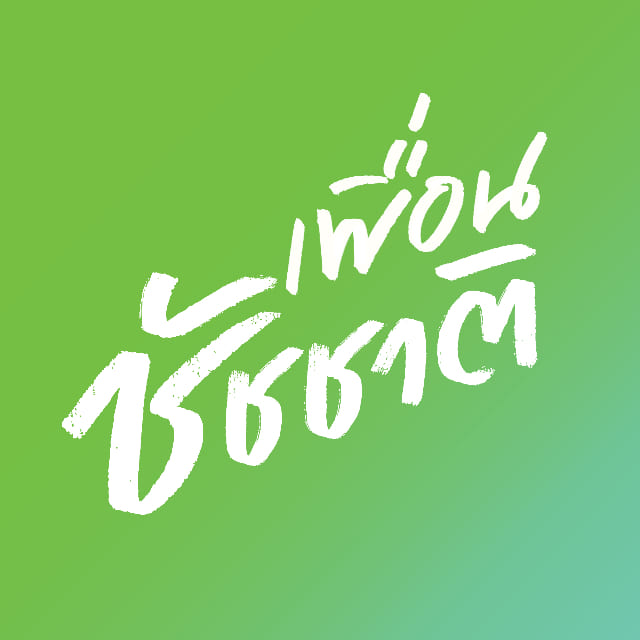

In [11]:
response = requests.get(df_remove.photo[244]) #รูปนี้ไม่มีประโยชน์_ลบออกหมดเลย 00000e3e7e784000
img = Image.open(BytesIO(response.content))
img

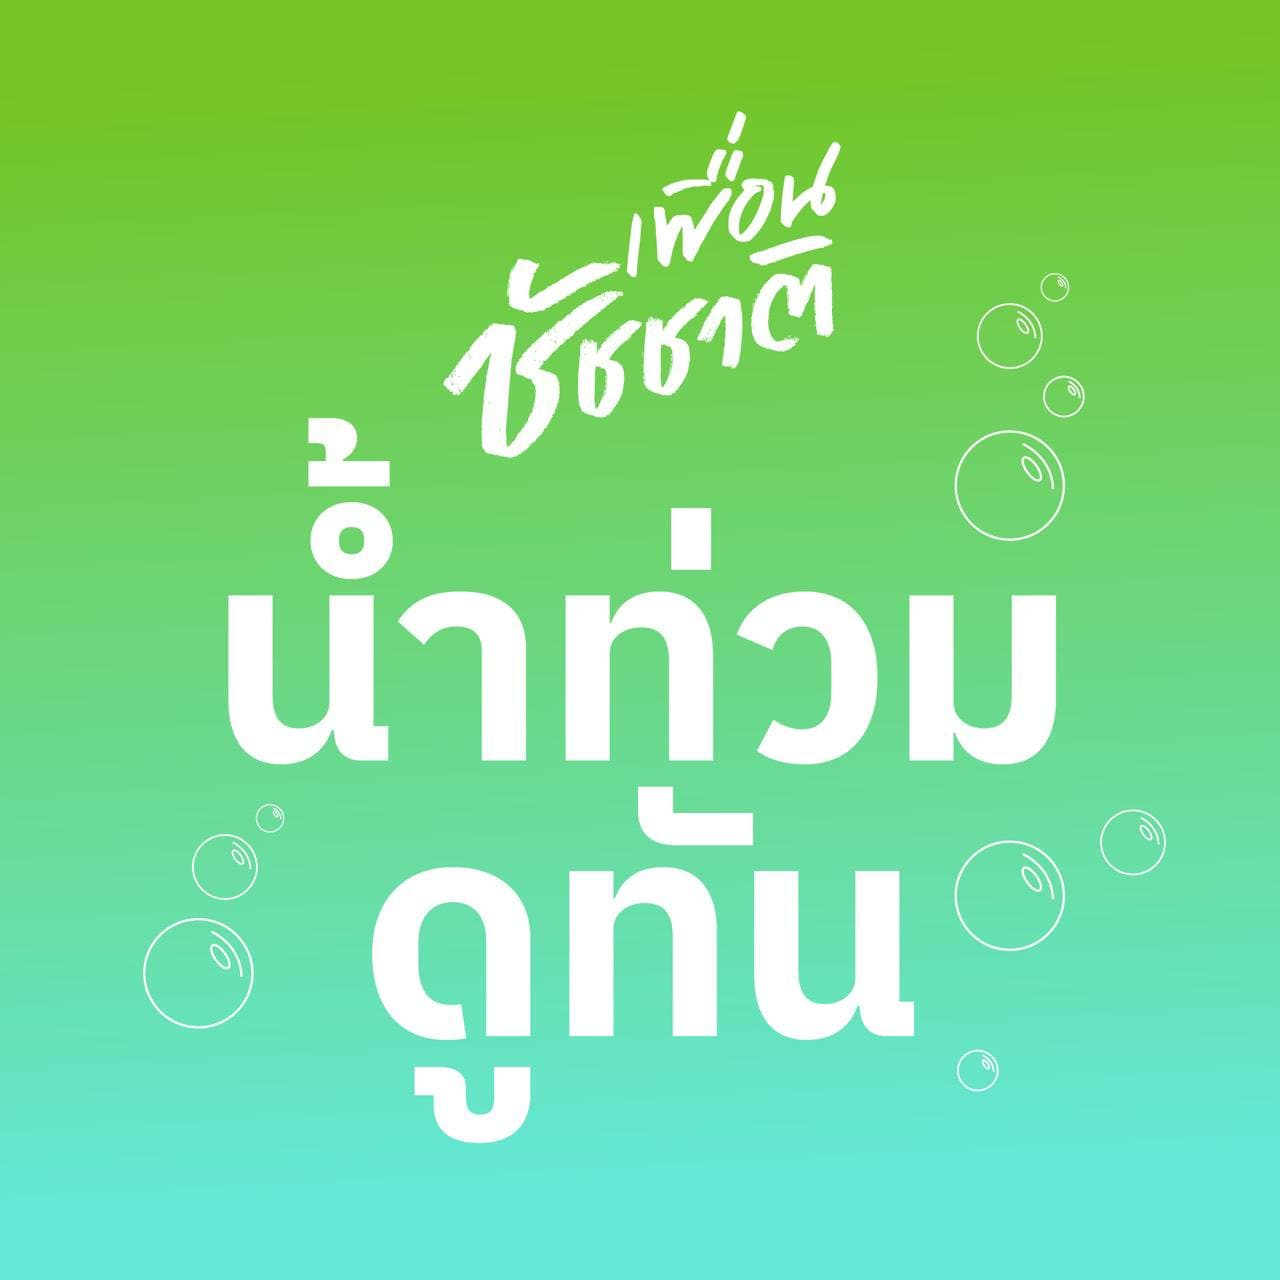

In [12]:
response = requests.get(df_remove.photo[835]) #รูปนี้ไม่มีประโยชน์_ลบออกหมดเลย 0008107c7e3fffff
img = Image.open(BytesIO(response.content))
img

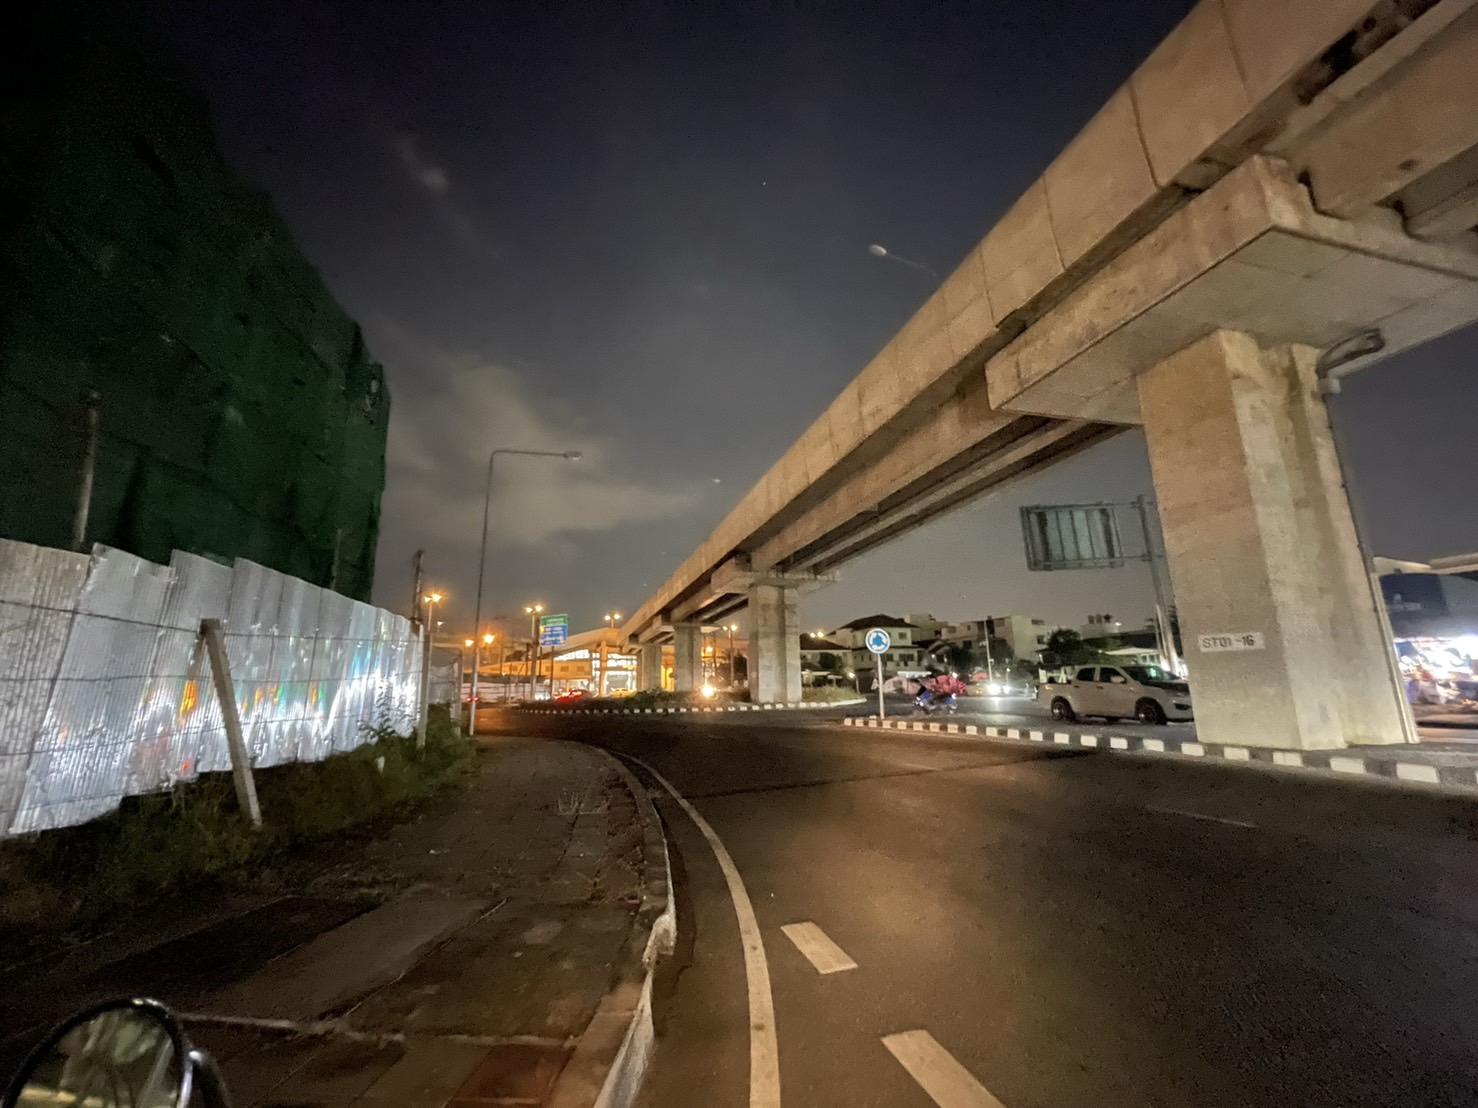

In [13]:
response = requests.get(df_remove.photo[98]) #รูปซ้ำ 1 รูป 03073f3fffcf081c
img = Image.open(BytesIO(response.content))
img

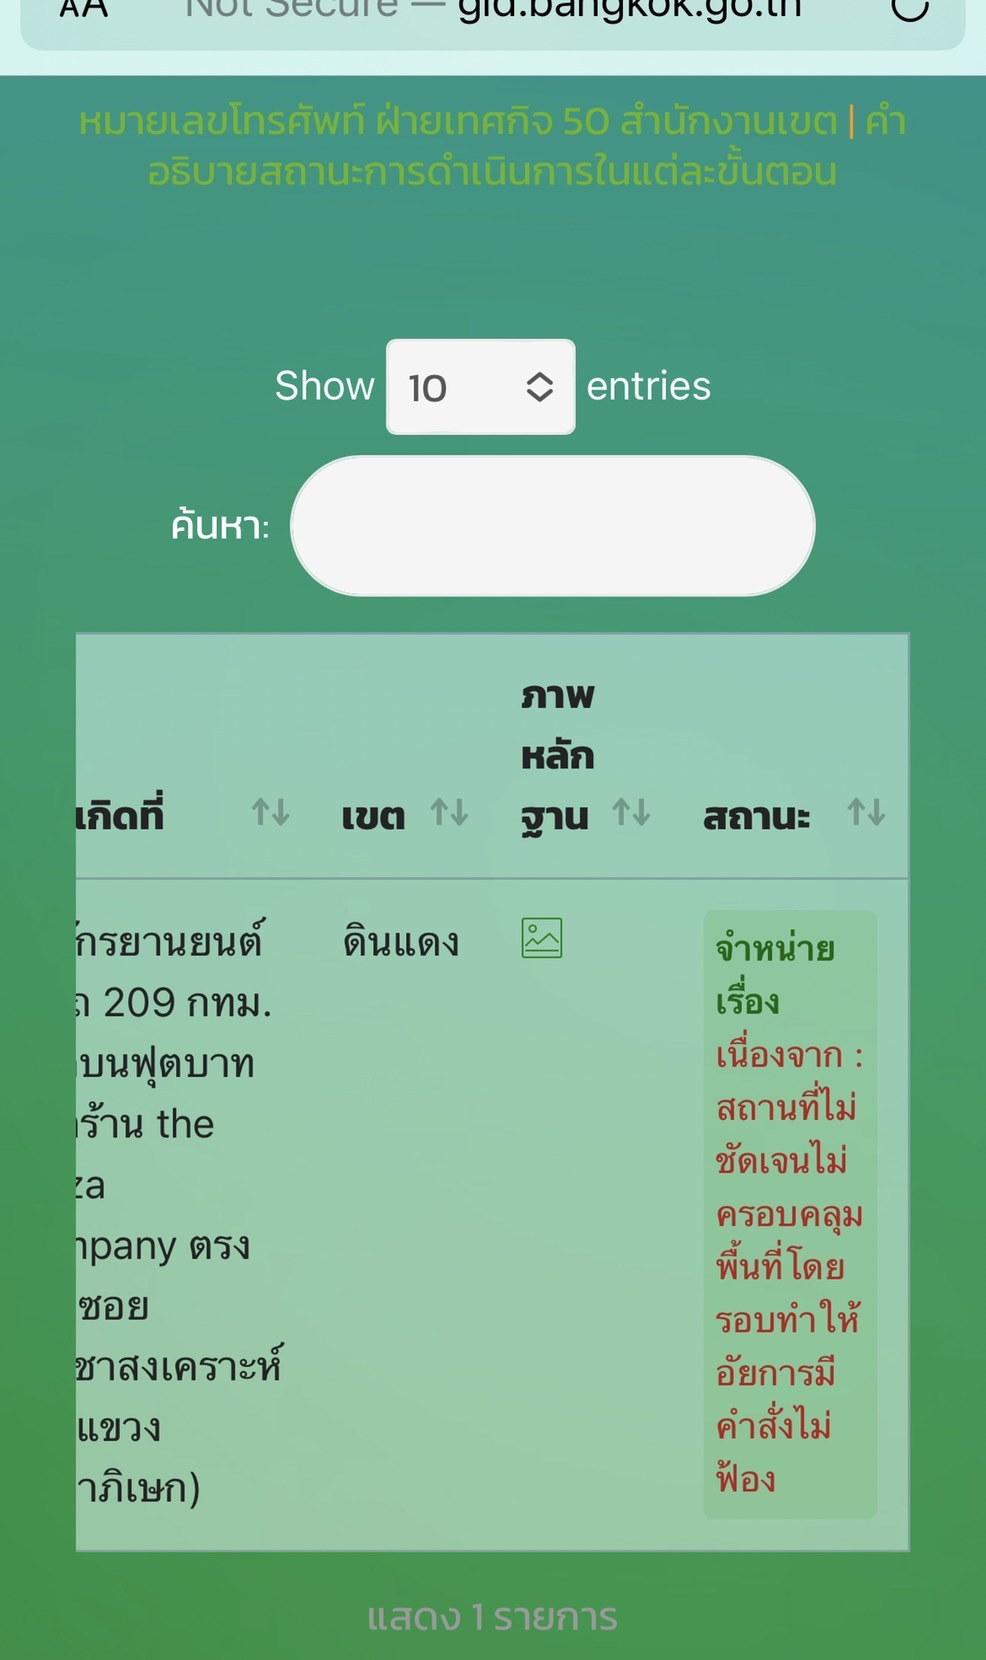

In [14]:
response = requests.get(df2.photo[0]) #รูปนี้ไม่มีประโยชน์_ลบออกหมดเลย 00003e7e7e7e7e00
img = Image.open(BytesIO(response.content))
img

3.8) drop table ที่มีค่า hash ซ้ำกันออกจาก table ข้อมูลทั้งหมด 

In [15]:
index_value = df_remove.index[2] #หา index ของรูปที่มีค่า 03073f3fffcf081c เนื่องจากต้องการลบเพียงภาพเดียว
index_value

98

In [16]:
df3 = df_remove.drop(df_remove.index[2]) #drop row ของรูป index ที่ 98 ซึ่งอยู่แถวที่ 2
df3.head(3)

type   organization  \
0        ทางเท้า  เพื่อนชัชชาติ   
1        ทางเท้า  เพื่อนชัชชาติ   
158  ความปลอดภัย  เพื่อนชัชชาติ   

                                               comment  \
0    สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
1    สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...   
158                                      ไฟถนนไม่ทำงาน   

                                  coords  \
0    [100.559517592192,13.7700838665743]   
1    [100.559512898326,13.7700848434939]   
158  [100.477227084339,13.7908362985148]   

                                                 photo  \
0    https://storage.googleapis.com/traffy_public_b...   
1    https://storage.googleapis.com/traffy_public_b...   
158  https://storage.googleapis.com/traffy_public_b...   

                                               address district subdistrict  \
0    ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
1    ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...   ดินแดง      ดินแดง   
158  344 สิรินธร แขวง บางพลัด เขตบางพลัด กรุงเทพมหา...  บางพลัด     บางพลัด   

          province                      timestamp              hash  
0    กรุงเทพมหานคร   2022-03-17 14:12:52.56103+00  00003e7e7e7e7e00  
1    กรุงเทพมหานคร  2022-03-17 13:44:37.242707+00  00003e7e7e7e7e00  
158  กรุงเทพมหานคร  2022-01-14 10:09:09.793096+00  03073f3fffcf081c

In [17]:
df4 = df2[~df2.isin(df3)].dropna(how = 'all') 
df4.head(3)

type   organization                                            comment  \
2  ทางเท้า  เพื่อนชัชชาติ  สวัสดีครับ ขอแจ้งเรื่องร้องทุกข์ชาวบ้านเดือนร้...   
3    จราจร  เพื่อนชัชชาติ  ชุมชนไม่มีทางออกถนนใหญ่ ในเขตประเวศ แขวงดอกไม้...   
4      ขยะ  เพื่อนชัชชาติ  เหตุเกิดบน ถ.พหลโยธิน บริเวณหน้าปากซอยหมู่บ้าน...   

                                coords  \
2               [100.474905,13.712991]   
3  [100.696346126497,13.6794261068856]   
4               [100.566734,13.824416]   

                                               photo  \
2  https://storage.googleapis.com/traffy_public_b...   
3  https://storage.googleapis.com/traffy_public_b...   
4  https://storage.googleapis.com/traffy_public_b...   

                                             address district subdistrict  \
2  789 ถนน ราชพฤกษ์ แขวง ตลาดพลู เขตธนบุรี กรุงเท...   จอมทอง      บางค้อ   
3  12 ซอย กาญจนาภิเษก 48 แขวง ดอกไม้ เขต ประเวศ ก...   ประเวศ      ดอกไม้   
4  1418/1 ถ. พหลโยธิน แขวง ลาดยาว เขตจตุจักร กรุง...  จตุจักร       จอมพล   

        province                      timestamp              hash  
2  กรุงเทพมหานคร  2022-03-15 13:36:10.447933+00  e0f072f838000000  
3  กรุงเทพมหานคร  2022-03-13 09:08:11.461257+00  fff87000c0f13830  
4  กรุงเทพมหานคร  2022-03-12 17:19:09.014693+00  f7f7f77701000000

### 4) ตรวจสอบข้อมูลและดาวน์โหลดรูปภาพในแต่ละ class เพิ่ม

4.1) เรียกดูข้อมูลในแต่ละ class

In [18]:
pavement = df4[df4['type'].str.contains("ทางเท้า")] #เรียกดูข้อมูล class ทางเท้า
pavement.head(2)

type   organization                                            comment  \
2  ทางเท้า  เพื่อนชัชชาติ  สวัสดีครับ ขอแจ้งเรื่องร้องทุกข์ชาวบ้านเดือนร้...   
6  ทางเท้า  เพื่อนชัชชาติ                                           แจ้งเหตุ   

                   coords                                              photo  \
2  [100.474905,13.712991]  https://storage.googleapis.com/traffy_public_b...   
6  [100.442324,13.776359]  https://storage.googleapis.com/traffy_public_b...   

                                             address  district subdistrict  \
2  789 ถนน ราชพฤกษ์ แขวง ตลาดพลู เขตธนบุรี กรุงเท...    จอมทอง      บางค้อ   
6  13/10 ถนน บรมราชชนนี แขวง ฉิมพลี เขตตลิ่งชัน ก...  ตลิ่งชัน      ฉิมพลี   

        province                      timestamp              hash  
2  กรุงเทพมหานคร  2022-03-15 13:36:10.447933+00  e0f072f838000000  
6  กรุงเทพมหานคร  2022-03-10 09:35:56.749477+00  e0f0c880ece8c0e5

In [19]:
traffic = df4[df4['type'].str.contains("จราจร")] #เรียกดูข้อมูล class จราจร
traffic.head(2)

type   organization                                            comment  \
3  จราจร  เพื่อนชัชชาติ  ชุมชนไม่มีทางออกถนนใหญ่ ในเขตประเวศ แขวงดอกไม้...   
8  จราจร  เพื่อนชัชชาติ  พื้นถนนบริเวณซอย วิภาวดีฯ ซอย 3 แผ่นถนนไม่ราบเ...   

                                coords  \
3  [100.696346126497,13.6794261068856]   
8               [100.558366,13.797092]   

                                               photo  \
3  https://storage.googleapis.com/traffy_public_b...   
8  https://storage.googleapis.com/traffy_public_b...   

                                             address district subdistrict  \
3  12 ซอย กาญจนาภิเษก 48 แขวง ดอกไม้ เขต ประเวศ ก...   ประเวศ      ดอกไม้   
8  65 ซอย วิภาวดีรังสิต 3 แขวง จอมพล เขตจตุจักร ก...  จตุจักร       จอมพล   

        province                      timestamp              hash  
3  กรุงเทพมหานคร  2022-03-13 09:08:11.461257+00  fff87000c0f13830  
8  กรุงเทพมหานคร  2022-03-08 05:37:27.983998+00  f8f8fef8f0f0f8fc

In [20]:
garbage = df4[df4['type'].str.contains("ขยะ")] #เรียกดูข้อมูล class ขยะ
garbage.head(2)

type   organization                                            comment  \
4  ขยะ  เพื่อนชัชชาติ  เหตุเกิดบน ถ.พหลโยธิน บริเวณหน้าปากซอยหมู่บ้าน...   
5  ขยะ  เพื่อนชัชชาติ  เหตุเกิดในซอยพหลโยธิน 24 บริเวณหน้า Seven Elev...   

                   coords                                              photo  \
4  [100.566734,13.824416]  https://storage.googleapis.com/traffy_public_b...   
5  [100.567246,13.823062]  https://storage.googleapis.com/traffy_public_b...   

                                             address district subdistrict  \
4  1418/1 ถ. พหลโยธิน แขวง ลาดยาว เขตจตุจักร กรุง...  จตุจักร       จอมพล   
5  4 ซอยพหลโยธิน 24 ถ. พหลโยธิน แขวง จอมพล เขตจตุ...  จตุจักร       จอมพล   

        province                      timestamp              hash  
4  กรุงเทพมหานคร  2022-03-12 17:19:09.014693+00  f7f7f77701000000  
5  กรุงเทพมหานคร  2022-03-12 17:15:11.621315+00  e8e8e0f0f8f87000

In [21]:
flood = df4[df4['type'].str.contains("น้ำท่วม")] #เรียกดูข้อมูล class น้ำท่วม
flood.head(2)

type   organization                   comment                  coords  \
13  น้ำท่วม  เพื่อนชัชชาติ            คูคลองตื่นเขิน  [100.491292,13.750072]   
62  น้ำท่วม  เพื่อนชัชชาติ  ฝนตกทีไรน้ำก็ท่วมรอระบาย  [100.530756,13.701845]   

                                                photo  \
13  https://storage.googleapis.com/traffy_public_b...   
62  https://storage.googleapis.com/traffy_public_b...   

                                              address   district  \
13  200 ถ. มหาราช แขวงพระบรมมหาราชวัง เขตพระนคร กร...     พระนคร   
62  193 ซอย สาธุประดิษฐ์ 9 แขวง ช่องนนทรี เขต ยานน...  บางคอแหลม   

        subdistrict       province                      timestamp  \
13  พระบรมมหาราชวัง  กรุงเทพมหานคร  2022-03-04 07:14:43.121366+00   
62          บางโคล่  กรุงเทพมหานคร    2022-02-09 10:38:05.8467+00   

                hash  
13  3e1e3c3c3c3c1c10  
62  ffff870f8f010000

In [22]:
safety = df4[df4['type'].str.contains("ความปลอดภัย")] #เรียกดูข้อมูล class ความปลอดภัย
safety.head(2)

type   organization  \
7  ความปลอดภัย  เพื่อนชัชชาติ   
9  ความปลอดภัย  เพื่อนชัชชาติ   

                                             comment  \
7                                              ฝาท่อ   
9  อยากรบกวนขอเปลี่ยนตะแกรงฝาท่อแยกราชวัตรครับ\nต...   

                                coords  \
7               [100.491815,13.730618]   
9  [100.522343851626,13.7794542911595]   

                                               photo  \
7  https://storage.googleapis.com/traffy_public_b...   
9  https://storage.googleapis.com/traffy_public_b...   

                                             address district   subdistrict  \
7  909 ซอย อิสรภาพ 13 แขวง หิรัญรูจี เขตธนบุรี กร...   ธนบุรี     หิรัญรูจี   
9  280 ถ. พระรามที่ ๕ แขวง ถนนดุสิต เขตดุสิต กรุง...    ดุสิต  ถนนนครไชยศรี   

        province                      timestamp              hash  
7  กรุงเทพมหานคร  2022-03-09 03:13:51.284742+00  f4f0f8f67b278301  
9  กรุงเทพมหานคร   2022-03-08 02:36:34.74517+00  bfb0a0039d9ce7c3

4.2) การดาวน์โหลดข้อมูลรูปภาพในแต่ละ class

4.3) เนื่องจากจำนวนรูปภาพในแต่ class มีจำนวนน้อย ผู้จัดทำจึงได้ดาวน์โหลดรูปภาพจากแหล่งอื่นมาเพิ่มในแต่ละ class 

4.4) สร้าง function เพื่อใช้ในการ hash ข้อมูล
- ทำการ hash เพื่อตรวจสอบว่ารูปภาพที่มีอยู่และรูปภาพที่ download มามีการซ้ำกันหรือไม่

In [23]:
def other_class_path(class_path): #สร้าง function ในการเก็บ path ของรูป
    path_file = []
    for filename in glob.iglob(class_path,recursive = True):
        path_file.append(filename)
    return path_file

In [24]:
def other_class_hash(path_file): #สร้าง function ในการหาค่า hash ของรูป
    other_hash = []
    for i in range(len(path_file)):
        avg_hash = imagehash.average_hash(Image.open(path_file[i]))
        other_hash.append(avg_hash)
    return other_hash

4.5) เรียกใช้ function เพื่อหาค่า hash ในแต่ละ class แล้วเก็บค่า hash ลงใน table 

- table garbage

In [25]:
garbage_file = other_class_path(r"C:\Users\Admin\Desktop\image_dataset\garbage\*.jpg") 
df_garbage = pd.DataFrame(garbage_file, columns =['path'])
garbage_hash = other_class_hash(garbage_file)
df_garbage["hash"] = garbage_hash
df_garbage

path              hash
0   C:\Users\Admin\Desktop\image_dataset\garbage\0...  e606161e06133f1e
1   C:\Users\Admin\Desktop\image_dataset\garbage\0...  0080c030fafe9cd8
2   C:\Users\Admin\Desktop\image_dataset\garbage\0...  2e6f8fbf2f070f1f
3   C:\Users\Admin\Desktop\image_dataset\garbage\1...  0000f2e1c7fef4e4
4   C:\Users\Admin\Desktop\image_dataset\garbage\1...  3d1d7a7f16000000
..                                                ...               ...
95  C:\Users\Admin\Desktop\image_dataset\garbage\t...  83c1ff9f97230307
96  C:\Users\Admin\Desktop\image_dataset\garbage\u...  1f9e80ccfcf84000
97  C:\Users\Admin\Desktop\image_dataset\garbage\U...  1f1f0f183e1f0000
98  C:\Users\Admin\Desktop\image_dataset\garbage\w...  03817322130f4fff
99  C:\Users\Admin\Desktop\image_dataset\garbage\w...  73f9bcfd785c6620

[100 rows x 2 columns]

In [26]:
count_hash_garbage = df_garbage["hash"].value_counts() #ดูว่าค่า hash มีการซ้ำกันหรือไม่
count_hash_garbage

e606161e06133f1e    1
8fcf178f0b001ffc    1
fdedc1408089c9e1    1
080e0c1c74702c00    1
1f5e0e010f0f7f7f    1
                   ..
0a078f010571371f    1
efffc4f0e0c0c0a0    1
f7f7f77701000000    1
070f0f1f1f1f1f0f    1
73f9bcfd785c6620    1
Name: hash, Length: 100, dtype: int64

- table traffic

In [27]:
traffic_file = other_class_path(r"C:\Users\Admin\Desktop\image_dataset\traffic\*.jpg") 
df_traffic = pd.DataFrame(traffic_file, columns =['path'])
traffic_hash = other_class_hash(traffic_file)
df_traffic["hash"] = traffic_hash
df_traffic

path              hash
0   C:\Users\Admin\Desktop\image_dataset\traffic\-...  61672f36706e6071
1   C:\Users\Admin\Desktop\image_dataset\traffic\1...  f0f0703007f3ffff
2   C:\Users\Admin\Desktop\image_dataset\traffic\1...  fffffff001010000
3   C:\Users\Admin\Desktop\image_dataset\traffic\1...  be3c203040c8f8fc
4   C:\Users\Admin\Desktop\image_dataset\traffic\1...  af8f80c8ff3c3800
..                                                ...               ...
95  C:\Users\Admin\Desktop\image_dataset\traffic\t...  7c1c8cf861c1e206
96  C:\Users\Admin\Desktop\image_dataset\traffic\t...  03073f3fffcf081c
97  C:\Users\Admin\Desktop\image_dataset\traffic\t...  c470fbffff0000ff
98  C:\Users\Admin\Desktop\image_dataset\traffic\t...  e0c00080e0fcfeff
99  C:\Users\Admin\Desktop\image_dataset\traffic\t...  1e0c0f0f47e7cfdf

[100 rows x 2 columns]

In [28]:
count_hash_traffic = df_traffic["hash"].value_counts() #ดูว่าค่า hash มีการซ้ำกันหรือไม่
count_hash_traffic

61672f36706e6071    1
ffffffbf03028100    1
1fcff71c00000100    1
f8f8fef8f0f0f8fc    1
fff87000c0f13830    1
                   ..
80808098dceef8ff    1
0d0163031b7f6fdf    1
1f1f1f1f1f0b053f    1
06040098fefefecc    1
1e0c0f0f47e7cfdf    1
Name: hash, Length: 100, dtype: int64

- table flood

In [29]:
flood_file = other_class_path(r"C:\Users\Admin\Desktop\image_dataset\flood\*.jpg") 
df_flood = pd.DataFrame(flood_file, columns =['path'])
flood_hash = other_class_hash(flood_file)
df_flood["hash"] = flood_hash
df_flood

path              hash
0   C:\Users\Admin\Desktop\image_dataset\flood\10-...  ff1910000d0f1f1f
1   C:\Users\Admin\Desktop\image_dataset\flood\10....  d81c181818181898
2   C:\Users\Admin\Desktop\image_dataset\flood\111...  d8dcdafaf3e18000
3   C:\Users\Admin\Desktop\image_dataset\flood\112...  1e0c0400c2871fff
4   C:\Users\Admin\Desktop\image_dataset\flood\112...  46016b3c3f6e277f
..                                                ...               ...
95  C:\Users\Admin\Desktop\image_dataset\flood\IMG...  f8a00030f8f8f8f8
96  C:\Users\Admin\Desktop\image_dataset\flood\new...  38381c0cfc3c3c38
97  C:\Users\Admin\Desktop\image_dataset\flood\PlO...  fffe10003030f8fc
98  C:\Users\Admin\Desktop\image_dataset\flood\qw0...  f8ffc7c02038f8fb
99  C:\Users\Admin\Desktop\image_dataset\flood\u00...  ffff9f1f181c0424

[100 rows x 2 columns]

In [30]:
count_hash_flood = df_flood["hash"].value_counts() #ดูว่าค่า hash มีการซ้ำกันหรือไม่
count_hash_flood

ff1910000d0f1f1f    1
a078fe3230602000    1
7f7f10007c7e0400    1
002370e153d33f3f    1
ff3f0010387c7e1f    1
                   ..
0000dcfcffefef3f    1
bad040c8e0f0bcfe    1
7c38383834323038    1
fffdb99000002464    1
ffff9f1f181c0424    1
Name: hash, Length: 100, dtype: int64

- table safety

In [33]:
safety_file = other_class_path(r"C:\Users\Admin\Desktop\image_dataset\safety\*.jpg") 
df_safety = pd.DataFrame(safety_file, columns =['path'])
safety_hash = other_class_hash(safety_file)
df_safety["hash"] = safety_hash
df_safety

path              hash
0   C:\Users\Admin\Desktop\image_dataset\safety\11...  0000c0ce0c0de9f9
1   C:\Users\Admin\Desktop\image_dataset\safety\12...  0f0f070f046c9d1d
2   C:\Users\Admin\Desktop\image_dataset\safety\13...  fdcdcd9cc081e1e0
3   C:\Users\Admin\Desktop\image_dataset\safety\14...  1eeeeefe00000000
4   C:\Users\Admin\Desktop\image_dataset\safety\8B...  80f8f87f2c283d01
..                                                ...               ...
95  C:\Users\Admin\Desktop\image_dataset\safety\sa...  10000c3fffff7fff
96  C:\Users\Admin\Desktop\image_dataset\safety\sa...  ff0f0f7f7ffee684
97  C:\Users\Admin\Desktop\image_dataset\safety\S_...  fe7e1fcfc7090c0e
98  C:\Users\Admin\Desktop\image_dataset\safety\TS...  00000018ffaf7fff
99  C:\Users\Admin\Desktop\image_dataset\safety\wm...  fffffff800000000

[100 rows x 2 columns]

In [34]:
count_hash_safety = df_safety["hash"].value_counts()#ดูว่าค่า hash มีการซ้ำกันหรือไม่
count_hash_safety

0000c0ce0c0de9f9    1
ed031fff0f000001    1
7f7fffef0f000000    1
fc7ce8c804604000    1
00000000101f2fff    1
                   ..
ffc100001c3f3f7f    1
0f0f0f0f0dc64020    1
fee00000f0fcd9f3    1
bfb0a0039d9ce7c3    1
fffffff800000000    1
Name: hash, Length: 100, dtype: int64

* table pavement

In [35]:
pavement_file = other_class_path(r"C:\Users\Admin\Desktop\image_dataset\pavement\*.jpg")
df_pavement = pd.DataFrame(pavement_file, columns =['path'])
pavement_hash = other_class_hash(pavement_file)
df_pavement["hash"] = pavement_hash
df_pavement

path              hash
0   C:\Users\Admin\Desktop\image_dataset\pavement\...  ff7f7f1000300000
1   C:\Users\Admin\Desktop\image_dataset\pavement\...  9e074f4f0b090002
2   C:\Users\Admin\Desktop\image_dataset\pavement\...  37060474043e7fff
3   C:\Users\Admin\Desktop\image_dataset\pavement\...  100078f8fcfeffe1
4   C:\Users\Admin\Desktop\image_dataset\pavement\...  f3e1e4c383212113
..                                                ...               ...
95  C:\Users\Admin\Desktop\image_dataset\pavement\...  1610307e7f7ffdfe
96  C:\Users\Admin\Desktop\image_dataset\pavement\...  c447673f3e3e3c1d
97  C:\Users\Admin\Desktop\image_dataset\pavement\...  00000f0048ffffff
98  C:\Users\Admin\Desktop\image_dataset\pavement\...  e8f0b010c2dcfeff
99  C:\Users\Admin\Desktop\image_dataset\pavement\...  0f1f1f1f0f070301

[100 rows x 2 columns]

In [36]:
count_hash_pavement = df_pavement["hash"].value_counts()#ดูว่าค่า hash มีการซ้ำกันหรือไม่
count_hash_pavement

ff7f7f1000300000    1
ffff9c000103ffff    1
0f0b1f3701049c7c    1
1f0f0f0f0e8c0d08    1
073fe0c8deff9c00    1
                   ..
c1e7e7defcb00000    1
e0f1fffe00c18000    1
0003ff3ffcf91900    1
e0f0e04cee4efcf8    1
0f1f1f1f0f070301    1
Name: hash, Length: 100, dtype: int64

#### สรุปข้อมูลเพื่อเตรียมความพร้อมก่อนเข้าโมเดล
- โดยมีการแบ่งข้อมูลเป็น folder train และ folder test
- ซึ่งใน folder train และ folder test จะมี folder ของรูปภาพแต่ละ class 
- โดยในแต่ละ class จะมีรูปทั้งหมด 100 รูป โดยแบ่งเป็น train 80 รูปและ test 20 รูป

### 5) นำเข้าข้อมูลที่จะใช้ในการเข้าโมเดล

5.1) นำเข้า dataset train และ test

In [37]:
train_data_dir = r"C:\Users\Admin\Desktop\train" #กำหนด path ของ folder train
train_data_dir = pathlib.Path(train_data_dir)
train_data_dir

WindowsPath('C:/Users/Admin/Desktop/train')

In [45]:
train_image_count = len(list(train_data_dir.glob('*/*'))) #จำนวนรูปภาพทั้งหมดใน folder trian
print(train_image_count)

400


In [39]:
test_data_dir = r"C:\Users\Admin\Desktop\test" #กำหนด path ของ folder test
test_data_dir = pathlib.Path(test_data_dir)
test_data_dir

WindowsPath('C:/Users/Admin/Desktop/test')

In [46]:
test_image_count = len(list(test_data_dir.glob('*/*'))) #จำนวนรูปภาพทั้งหมดใน folder trian
print(test_image_count)

100


5.2) สร้าง dictionary ในการเก็บ list ของ path รูปภาพในแต่ละ class

In [47]:
#สร้าง dictionary เพื่อเก็บ list รูปภาพที่ใช้ในการ train ของแต่ละ class
train_images_dict = {
    'flood': list(train_data_dir.glob('flood/*')), 
    'garbage': list(train_data_dir.glob('garbage/*')),
    'pavement': list(train_data_dir.glob('pavement/*')),
    'safety': list(train_data_dir.glob('safety/*')),
    'traffic': list(train_data_dir.glob('traffic/*')),
} 

In [48]:
#สร้าง dictionary เพื่อเก็บ list รูปภาพที่ใช้ในการ test ของแต่ละ class
test_images_dict = {
    'flood': list(test_data_dir.glob('flood/*')),
    'garbage': list(test_data_dir.glob('garbage/*')),
    'pavement': list(test_data_dir.glob('pavement/*')),
    'safety': list(test_data_dir.glob('safety/*')),
    'traffic': list(test_data_dir.glob('traffic/*')),
} 

5.3) สร้าง dict ในการกำหนด label ของแต่ละ class

In [49]:
#สร้าง dictionary เพื่อกำหนด label ในแต่ละ class ของรูปภาพใช้ในการ train
train_labels_dict = {
    'flood': 0,
    'garbage': 1,
    'pavement': 2,
    'safety': 3,
    'traffic': 4,
} 

In [50]:
#สร้าง dictionary เพื่อกำหนด label ในแต่ละ class ของรูปภาพใช้ในการ test
test_labels_dict = {
    'flood': 0,
    'garbage': 1,
    'pavement': 2,
    'safety': 3,
    'traffic': 4,
} 

### 6) Convolutional Neural Network (CNN) และ CNN with Augmentation

ในหัวข้อนี้จะแบ่งออกเป็น 3 หัวข้อใหญ่ ดังนี้
- เตรียมข้อมูลก่อนเข้าโมเดล CNN
- โมเดล CNN
- โมเดล CNN with Augmentation

6.1) เตรียมข้อมูลก่อนเข้าโมเดล CNN

    6.1.1) เปลี่ยนรูปภาพให้อยู่ในรูปแบบ matrix RGB โดยมีการ resize รูปภาพให้อยู่ในขนาด 180 * 180 และมีการเก็บ label ของรูป

In [51]:
#สร้าง loop เพื่อใช้ในการเก็บรูปภาพที่อยู่ในรูปแบบ matrix RGB โดยมีการ resize รูปภาพเป็นขนาด 180*180 และมีการเก็บ label ของรูปที่ใช้ในการ train
X_train, y_train = [], [] 

for file_name, images in train_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X_train.append(resized_img)
        y_train.append(train_labels_dict[file_name])

In [52]:
#สร้าง loop เพื่อใช้ในการเก็บรูปภาพที่อยู่ในรูปแบบ matrix RGB โดยมีการ resize รูปภาพเป็นขนาด 180*180 และมีการเก็บ label ของรูปที่ใช้ในการ train
X_test, y_test = [], [] 

for file_name, images in test_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X_test.append(resized_img)
        y_test.append(test_labels_dict[file_name])

    6.1.2) เปลี่ยนข้อมูลให้อยู่ในรูป array

In [53]:
#เปลี่ยน list ให้อยู่ในรูป array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

    6.1.3) เปลี่ยน y ให้อยู่ในรูป one-hot และทำการ rescale X 

In [54]:
#เปลี่ยน y ซึ่งคือ label ให้อยู่ในรูปแบบ one-hot 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [55]:
y_train_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [56]:
#การ rescle รูปภาพ (X) ให้อยู่ในช่วง 0-1
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [57]:
X_train_scaled

array([[[[0.4745098 , 0.55686275, 0.54901961],
         [0.49411765, 0.56862745, 0.58823529],
         [0.52941176, 0.58431373, 0.57647059],
         ...,
         [0.23137255, 0.29411765, 0.32156863],
         [0.21568627, 0.27843137, 0.30588235],
         [0.20784314, 0.27058824, 0.29411765]],

        [[0.50588235, 0.58823529, 0.58039216],
         [0.49411765, 0.56862745, 0.58823529],
         [0.51372549, 0.56862745, 0.56078431],
         ...,
         [0.25490196, 0.30196078, 0.33333333],
         [0.25490196, 0.30196078, 0.33333333],
         [0.2627451 , 0.30980392, 0.34117647]],

        [[0.52156863, 0.60392157, 0.59607843],
         [0.54509804, 0.61568627, 0.63921569],
         [0.56078431, 0.61568627, 0.60784314],
         ...,
         [0.20392157, 0.23921569, 0.2745098 ],
         [0.19607843, 0.23137255, 0.26666667],
         [0.18823529, 0.22352941, 0.25882353]],

        ...,

        [[0.48627451, 0.46666667, 0.45490196],
         [0.48235294, 0.4627451 , 0.45098039]

In [58]:
#ดูจำนวน shape ของข้อมูลที่จะใช้ในการ train และ test
X_train_scaled.shape, y_train_one_hot.shape, X_test_scaled.shape, y_test_one_hot.shape

((400, 180, 180, 3), (400, 5), (100, 180, 180, 3), (100, 5))

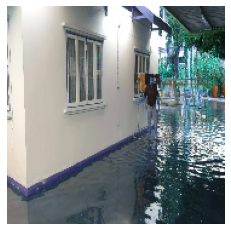

In [59]:
#แสดงตัวอย่างรูปภาพที่ใช้ในการ train
plt.axis('off')
plt.imshow(X_train_scaled[0])

6.2) โมเดล CNN

    6.2.1) สร้าง architecture ของโมเดล CNN

In [60]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape = (180,180, 3)),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'), #128 คือจำนวน neurons
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

    6.2.2) ทำการ train โมเดล CNN

In [61]:
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
#ทำการ fit ข้อมูล โดยมีการกำหนด batch, จำนวนรอบ epoch, สัดส่วนการ split ข้อมูลเพื่อ validation
history = model.fit(X_train_scaled, y_train_one_hot, batch_size = 20, epochs = 30, validation_split = 0.1)

Epoch 1/30
18/18 [==============================] - 8s 288ms/step - loss: 1.8269 - accuracy: 0.2278 - val_loss: 1.8445 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 5s 278ms/step - loss: 1.5626 - accuracy: 0.2444 - val_loss: 1.7722 - val_accuracy: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 5s 296ms/step - loss: 1.4399 - accuracy: 0.4389 - val_loss: 2.0425 - val_accuracy: 0.1750
Epoch 4/30
18/18 [==============================] - 5s 264ms/step - loss: 1.2006 - accuracy: 0.5389 - val_loss: 2.4638 - val_accuracy: 0.1500
Epoch 5/30
18/18 [==============================] - 5s 262ms/step - loss: 0.8785 - accuracy: 0.6806 - val_loss: 2.3464 - val_accuracy: 0.1250
Epoch 6/30
18/18 [==============================] - 5s 261ms/step - loss: 0.5358 - accuracy: 0.8389 - val_loss: 2.6858 - val_accuracy: 0.1250
Epoch 7/30
18/18 [==============================] - 5s 260ms/step - loss: 0.3005 - accuracy: 0.9278 - val_loss: 4.5497 - val_accuracy: 0.075

    6.2.3) ทำการ Evaluate โมเดล CNN

In [63]:
#evaluate model เพื่อดูค่า loss และค่า accuracy ของโมเดล
model.evaluate(X_test_scaled, y_test_one_hot)

4/4 [==============================] - 0s 61ms/step - loss: 4.1097 - accuracy: 0.3700


[4.109707832336426, 0.3700000047683716]

In [64]:
#ดูค่า metric ต่าง ๆ ในแต่ละ class
y_pred = model.predict(X_test_scaled)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.38      0.60      0.46        20
           1       0.38      0.40      0.39        20
           2       0.28      0.25      0.26        20
           3       0.41      0.35      0.38        20
           4       0.42      0.25      0.31        20

    accuracy                           0.37       100
   macro avg       0.37      0.37      0.36       100
weighted avg       0.37      0.37      0.36       100



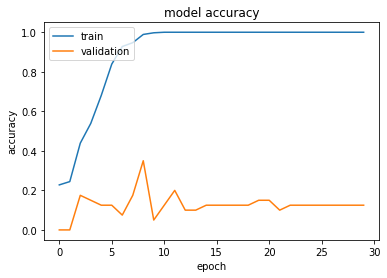

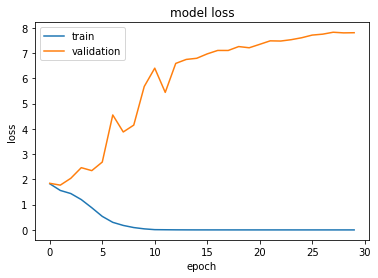

In [65]:
#กราฟแสดงผลค่า accuracy และค่า loss ของโมเดล
# "accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**สรุป** จากโมเดล CNN ข้างต้นจะเห็นว่าโมเดลมีการ overfitting เห็นได้จากค่า accuracy ของข้อมูล train ที่มีค่าเป็น 1 และค่า loss ของข้อมูล validation มีค่าสูง

    6.2.4) ทดสอบการทำนายข้อมูล test ด้วยโมเดล CNN

In [106]:
#แสดงค่า prediction ที่ได้จากการทำนายข้อมูล test
pred_cnn = model.predict(X_test_scaled)
pred_cnn

array([[9.85702157e-01, 1.18808930e-04, 4.07714816e-03, 9.63084213e-03,
        4.71051550e-04],
       [9.99963880e-01, 3.96633641e-06, 2.47413868e-06, 2.96706858e-05,
        4.05014866e-09],
       [1.43457325e-02, 1.75476634e-06, 9.69541073e-01, 3.80252386e-05,
        1.60734858e-02],
       [9.99588788e-01, 3.80212805e-05, 3.71069560e-04, 1.05313632e-06,
        1.03629486e-06],
       [6.66051447e-01, 2.12055777e-04, 3.12719166e-01, 2.10124329e-02,
        4.92155641e-06],
       [7.38764942e-01, 8.47877003e-04, 1.33013193e-04, 2.60253787e-01,
        4.50199906e-07],
       [2.44854912e-01, 8.61446460e-06, 1.22341691e-02, 7.37254262e-01,
        5.64811938e-03],
       [9.99952078e-01, 7.57690577e-10, 2.29720149e-11, 4.79603332e-05,
        4.20358148e-09],
       [3.56860220e-01, 2.14609876e-01, 4.28229719e-01, 6.97252399e-05,
        2.30392034e-04],
       [9.65538144e-01, 2.92123853e-10, 4.02897094e-05, 3.43142524e-02,
        1.07218235e-04],
       [3.76450131e-03, 9.3253

The prediction class of image is: flood
The real class of image is: flood
flood : 98.5702 %
garbage : 0.0119 %
pavement : 0.4077 %
safety : 0.9631 %
traffic : 0.0471 %


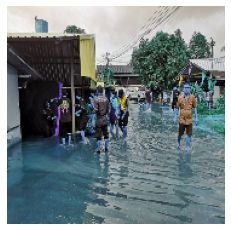

------------------------------------------------------
The prediction class of image is: pavement
The real class of image is: garbage
flood : 0.0257 %
garbage : 0.1539 %
pavement : 98.8154 %
safety : 0.0041 %
traffic : 1.0009 %


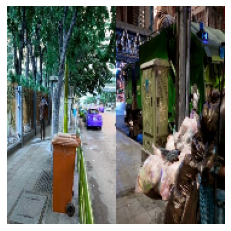

------------------------------------------------------
The prediction class of image is: traffic
The real class of image is: traffic
flood : 2.998 %
garbage : 5.2446 %
pavement : 5.0959 %
safety : 0.8714 %
traffic : 85.7901 %


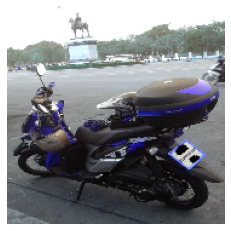

------------------------------------------------------


In [107]:
#แสดงตัวอย่างของผลการทำนาย test

classification = ['flood','garbage','pavement','safety','traffic']
list_index = [0,1,2,3,4]
index_img = [0,21,81]


for j in index_img:
    pred = model.predict(X_test_scaled)
    print('The prediction class of image is:', classification[np.argmax(pred_cnn[j])])
    print('The real class of image is:', classification[y_test[j]])
    for i in range(5):       
        print(classification[list_index[i]], ':', round(pred_cnn[j][list_index[i]]*100,4),'%') 
    plt.axis('off')
    plt.imshow(X_test[j])
    plt.show() 
    print('------------------------------------------------------')

6.3) CNN with Augmentation

    6.3.1) การทำ augmentation 
- เพื่อลดการ overfitting ของโมเดล

In [124]:
data_augmentation = keras.Sequential(
  [
      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(180, 180,3)), #การ flip รูปภาพ
      layers.experimental.preprocessing.RandomRotation(0.1), #การหมุนรูปภาพ
      layers.experimental.preprocessing.RandomZoom(0.1), #การซูมรูปภาพ
  ]
)

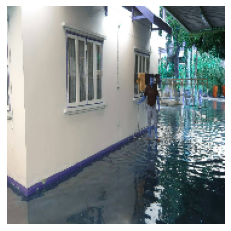

In [127]:
#ตัวอย่างรูปภาพเมื่อมีการทำ augmentation
plt.axis('off')
plt.imshow(data_augmentation(X_train_scaled)[0])

    6.3.2) สร้าง architecture ของโมเดล CNN with Augmentation
- มีการเพิ่ม augmentation และ layer dropout

In [68]:
num_classes = 5

model_aug = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape = (180,180,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

    6.3.3) ทำการ train โมเดล CNN with Augmentation

In [69]:
#การ complie โมเดล โดยมีการกำหนด learning rate ด้วย
model_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
#ทำการ fit ข้อมูล โดยมีการกำหนด batch, รอบ epoch, การ split ข้อมูลเพื่อ validation
augment_history = model_aug.fit(X_train_scaled, y_train_one_hot, batch_size = 20, epochs = 30,validation_split = 0.1)

Epoch 1/30
18/18 [==============================] - 7s 315ms/step - loss: 1.6133 - accuracy: 0.2000 - val_loss: 2.4476 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 5s 299ms/step - loss: 1.5880 - accuracy: 0.2500 - val_loss: 2.1315 - val_accuracy: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 5s 296ms/step - loss: 1.5768 - accuracy: 0.2889 - val_loss: 2.1969 - val_accuracy: 0.0000e+00
Epoch 4/30
18/18 [==============================] - 5s 295ms/step - loss: 1.5704 - accuracy: 0.3083 - val_loss: 2.2344 - val_accuracy: 0.0000e+00
Epoch 5/30
18/18 [==============================] - 5s 299ms/step - loss: 1.5560 - accuracy: 0.3250 - val_loss: 2.2010 - val_accuracy: 0.0000e+00
Epoch 6/30
18/18 [==============================] - 5s 295ms/step - loss: 1.5585 - accuracy: 0.2667 - val_loss: 2.0111 - val_accuracy: 0.0000e+00
Epoch 7/30
18/18 [==============================] - 5s 295ms/step - loss: 1.5532 - accuracy: 0.3194 - val_loss: 2.3036 - val

    6.3.4) ทำการ Evaluate โมเดล CNN with Augmentation

In [71]:
#evaluate model เพื่อดูค่า loss และค่า accuracy ของโมเดล
model_aug.evaluate(X_test_scaled,y_test_one_hot)

4/4 [==============================] - 0s 68ms/step - loss: 1.4188 - accuracy: 0.3700


[1.418766975402832, 0.3700000047683716]

In [72]:
#ดูค่า metric ต่าง ๆ ในแต่ละ class
y_pred_aug = model_aug.predict(X_test_scaled)
y_pred_classes_aug = [np.argmax(element) for element in y_pred_aug]

print("Classification Report: \n", classification_report(y_test, y_pred_classes_aug))

Classification Report: 
               precision    recall  f1-score   support

           0       0.35      0.40      0.37        20
           1       0.41      0.55      0.47        20
           2       0.40      0.10      0.16        20
           3       0.35      0.55      0.43        20
           4       0.36      0.25      0.29        20

    accuracy                           0.37       100
   macro avg       0.37      0.37      0.35       100
weighted avg       0.37      0.37      0.35       100



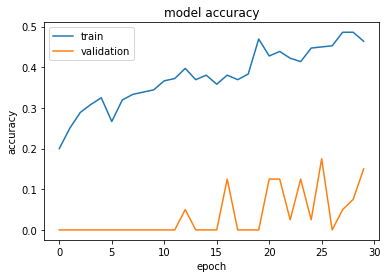

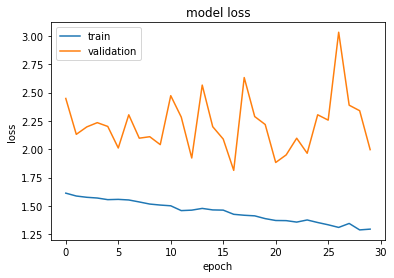

In [73]:
#กราฟแสดงผลค่า accuracy และค่า loss ของโมเดล
# "accuracy"
plt.plot(augment_history.history['accuracy'])
plt.plot(augment_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(augment_history.history['loss'])
plt.plot(augment_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**สรุป** จากโมเดล CNN with Augmentation ข้างต้นจะเห็นว่าโมเดลมีค่า accuracy ของข้อมูล train ที่มีค่าลดลงจากโมเดลก่อนหน้าและค่า loss ของข้อมูล validation มีค่าลดลง 

*ดังนั้นสรุปได้ว่า การทำ augmentation และการเพิ่ม layer drop out ช่วยในการแก้ปัญหาในเรื่องนี้ได้*

    6.3.5) ทดสอบการทำนายข้อมูล test ด้วยโมเดล CNN with Augmentation

In [123]:
#แสดงค่า prediction ที่ได้จากการทำนายข้อมูล test
pred = model_aug.predict(X_test_scaled)
pred

array([[0.3547795 , 0.1503016 , 0.15951361, 0.13295855, 0.20244671],
       [0.63914627, 0.17419247, 0.07194389, 0.07598726, 0.03873005],
       [0.2005829 , 0.25782242, 0.09475201, 0.09016002, 0.35668263],
       [0.5030638 , 0.13127792, 0.17256553, 0.10704537, 0.08604734],
       [0.14586586, 0.3504832 , 0.25684246, 0.187628  , 0.05918046],
       [0.11653394, 0.14918719, 0.25848898, 0.29861587, 0.17717406],
       [0.38816375, 0.06802511, 0.16320616, 0.18936986, 0.1912352 ],
       [0.44939166, 0.044936  , 0.1431314 , 0.14786716, 0.21467377],
       [0.1497673 , 0.22572978, 0.28779978, 0.22789316, 0.10881003],
       [0.2226948 , 0.28465632, 0.23399581, 0.15204978, 0.10660318],
       [0.14386357, 0.35188907, 0.22433741, 0.13991931, 0.13999069],
       [0.33133343, 0.16278464, 0.1527695 , 0.1399656 , 0.21314692],
       [0.02575324, 0.04530864, 0.0645933 , 0.68983305, 0.17451172],
       [0.07800739, 0.5548037 , 0.03584224, 0.1709003 , 0.1604464 ],
       [0.25654036, 0.04128265, 0.

The prediction class of image is: flood
The real class of image is: flood
flood : 35.478 %
garbage : 15.0302 %
pavement : 15.9514 %
safety : 13.2959 %
traffic : 20.2447 %


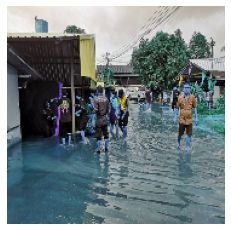

------------------------------------------------------
The prediction class of image is: safety
The real class of image is: garbage
flood : 6.7791 %
garbage : 29.8412 %
pavement : 12.914 %
safety : 41.2837 %
traffic : 9.1819 %


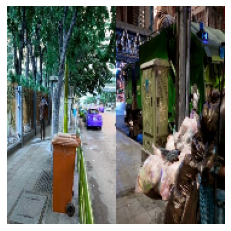

------------------------------------------------------
The prediction class of image is: safety
The real class of image is: traffic
flood : 6.7185 %
garbage : 10.5882 %
pavement : 11.2336 %
safety : 52.068 %
traffic : 19.3917 %


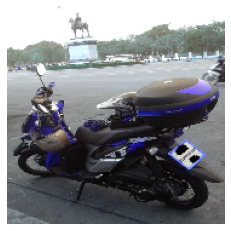

------------------------------------------------------


In [75]:
#แสดงตัวอย่างของผลการทำนาย test

classification = ['flood','garbage','pavement','safety','traffic']
list_index = [0,1,2,3,4]
index_img = [0,21,81]


for j in index_img:
    pred = model_aug.predict(X_test_scaled)
    print('The prediction class of image is:', classification[np.argmax(pred[j])])
    print('The real class of image is:', classification[y_test[j]])
    for i in range(5):       
        print(classification[list_index[i]], ':', round(pred[j][list_index[i]]*100,4),'%') 
    plt.axis('off')
    plt.imshow(X_test[j])
    plt.show() 
    print('------------------------------------------------------')

### 7) MobileNetV2
ในหัวข้อนี้จะแบ่งออกเป็น 2 หัวข้อใหญ่ ดังนี้
- เตรียมข้อมูลก่อนเข้าโมเดล MobileNetV2
- โมเดล MobileNetV2

7.1) เตรียมข้อมูลก่อนเข้าโมเดล MobileNetV2

    7.1.1) เปลี่ยนรูปภาพให้อยู่ในรูปแบบ matrix RGB โดยมีการ resize รูปภาพให้อยู่ในขนาด 128 * 128 และมีการเก็บ label ของรูป

In [76]:
#สร้าง loop เพื่อใช้ในการเก็บรูปภาพที่อยู่ในรูปแบบ metric RGB โดยมีการ resize รูปภาพเป็นขนาด 128*128 และมีการเก็บ label ของรูปที่ใช้ในการ train
X_train_mb, y_train_mb = [], [] 

for file_name, images in train_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X_train_mb.append(resized_img)
        y_train_mb.append(train_labels_dict[file_name])

In [77]:
#สร้าง loop เพื่อใช้ในการเก็บรูปภาพที่อยู่ในรูปแบบ metric RGB โดยมีการ resize รูปภาพเป็นขนาด 128*128 และมีการเก็บ label ของรูปที่ใช้ในการ test
X_test_mb, y_test_mb = [], [] 

for file_name, images in test_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X_test_mb.append(resized_img)
        y_test_mb.append(test_labels_dict[file_name])

    7.1.2) เปลี่ยนข้อมูลให้อยู่ในรูป array

In [78]:
X_train_mb = np.array(X_train_mb)
y_train_mb = np.array(y_train_mb)
X_test_mb = np.array(X_test_mb)
y_test_mb = np.array(y_test_mb)

    7.1.3) เปลี่ยน y ให้อยู่ในรูป one-hot

In [79]:
#เปลี่ยน y ซึ่งคือ label ให้อยู่ในรูปแบบ one-hot 
y_train_mb_one_hot = to_categorical(y_train)
y_test_mb_one_hot = to_categorical(y_test)

In [80]:
#ดูจำนวน shape ของข้อมูลที่จะใช้ในการ train และ test
X_train_mb.shape,y_train_mb.shape, X_test_mb.shape, y_test_mb.shape

((400, 128, 128, 3), (400,), (100, 128, 128, 3), (100,))

In [81]:
X_train_mb

array([[[[117, 137, 138],
         [132, 146, 144],
         [141, 155, 153],
         ...,
         [ 59,  71,  77],
         [ 42,  58,  65],
         [ 45,  61,  68]],

        [[131, 151, 152],
         [140, 154, 152],
         [148, 162, 160],
         ...,
         [ 59,  71,  77],
         [ 62,  71,  80],
         [ 55,  64,  73]],

        [[141, 156, 158],
         [148, 162, 160],
         [157, 171, 167],
         ...,
         [ 66,  78,  84],
         [ 67,  78,  86],
         [ 70,  79,  88]],

        ...,

        [[123, 118, 115],
         [124, 119, 116],
         [121, 116, 113],
         ...,
         [ 20,  32,  38],
         [ 19,  31,  37],
         [ 18,  27,  36]],

        [[123, 118, 115],
         [123, 118, 115],
         [123, 118, 115],
         ...,
         [ 19,  31,  37],
         [ 19,  31,  37],
         [ 19,  31,  37]],

        [[127, 122, 119],
         [124, 119, 116],
         [124, 119, 116],
         ...,
         [ 16,  28,  34],
        

In [82]:
y_train_mb_one_hot 

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

7.2) โมเดล MobileNetV2

    7.2.1) สร้าง architecture ของโมเดล MobileNetV2

In [83]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (128,128,3),
                                                include_top = False,
                                                weights = "imagenet")


base_model.trainable = False
num_classes = 5

model_mobile = Sequential([
    base_model,
    layers.Conv2D(128, 3, activation='relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),    
    layers.Flatten(),
    layers.Dense(num_classes,activation='softmax')
])

model_mobile .summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 128)         1474688   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 128)         0         
                                                                 
 dense_4 (Dense)             (None, 1, 1, 16)          2064      
                                                                 
 flatten_2 (Flatten)         (None, 16)               

    7.2.2) ทำการ train โมเดล MobileNetV2

In [84]:
#การ complie โมเดล โดยมีการกำหนด learning rate ด้วย
model_mobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
#ทำการ fit ข้อมูล โดยมีการกำหนด batch, รอบ epoch, การ split ข้อมูลเพื่อ validation
model_mb_hist = model_mobile.fit(X_train_mb, y_train_mb_one_hot, batch_size = 20, epochs = 30,validation_split = 0.1)

Epoch 1/30
18/18 [==============================] - 6s 210ms/step - loss: 1.7689 - accuracy: 0.2389 - val_loss: 2.3002 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 3s 172ms/step - loss: 1.5336 - accuracy: 0.3361 - val_loss: 1.9026 - val_accuracy: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 3s 169ms/step - loss: 1.3640 - accuracy: 0.4000 - val_loss: 2.3245 - val_accuracy: 0.0250
Epoch 4/30
18/18 [==============================] - 3s 163ms/step - loss: 1.3011 - accuracy: 0.4472 - val_loss: 2.2385 - val_accuracy: 0.1000
Epoch 5/30
18/18 [==============================] - 3s 161ms/step - loss: 1.2139 - accuracy: 0.4583 - val_loss: 2.7853 - val_accuracy: 0.0750
Epoch 6/30
18/18 [==============================] - 3s 161ms/step - loss: 1.1350 - accuracy: 0.5417 - val_loss: 2.2420 - val_accuracy: 0.2500
Epoch 7/30
18/18 [==============================] - 3s 161ms/step - loss: 1.0023 - accuracy: 0.6056 - val_loss: 2.7988 - val_accuracy: 0.175

    7.2.3) ทำการ Evaluate โมเดล MobileNetV2

In [86]:
#evaluate model เพื่อดูค่า loss และค่า accuracy ของโมเดล
model_mobile.evaluate(X_test_mb,y_test_mb_one_hot)

4/4 [==============================] - 1s 148ms/step - loss: 2.0511 - accuracy: 0.3800


[2.0511395931243896, 0.3799999952316284]

In [87]:
#ดูค่า metric ต่าง ๆ ในแต่ละ class
y_pred_mb = model_mobile.predict(X_test_mb)
y_pred_classes_mb = [np.argmax(element) for element in y_pred_mb]

print("Classification Report: \n", classification_report(y_test, y_pred_classes_mb))

Classification Report: 
               precision    recall  f1-score   support

           0       0.30      0.65      0.41        20
           1       0.50      0.50      0.50        20
           2       0.67      0.20      0.31        20
           3       0.29      0.20      0.24        20
           4       0.41      0.35      0.38        20

    accuracy                           0.38       100
   macro avg       0.43      0.38      0.37       100
weighted avg       0.43      0.38      0.37       100



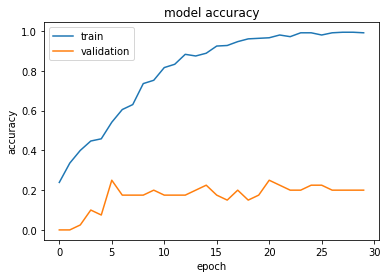

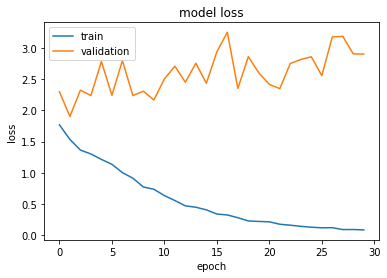

In [88]:
#กราฟแสดงผลค่า accuracy และค่า loss ของโมเดล
# "accuracy"
plt.plot(model_mb_hist.history['accuracy'])
plt.plot(model_mb_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model_mb_hist.history['loss'])
plt.plot(model_mb_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

    7.2.4) ทดสอบการทำนายข้อมูล test ด้วยโมเดล MobileNetV2

In [89]:
#แสดงค่า prediction ที่ได้จากการทำนายข้อมูล test
pred_mb = model_mobile.predict(X_test_mb)
pred_mb

array([[4.54264879e-01, 2.19329968e-02, 1.78238407e-01, 3.41263056e-01,
        4.30067396e-03],
       [9.16316211e-01, 7.65964836e-02, 5.68799581e-03, 1.31116225e-03,
        8.81486631e-05],
       [7.09665835e-01, 1.81039423e-01, 6.01694779e-03, 1.93408076e-02,
        8.39369968e-02],
       [9.49161530e-01, 4.41984907e-02, 1.13893293e-04, 4.70119994e-03,
        1.82484125e-03],
       [3.77859563e-01, 4.63034242e-01, 2.04240177e-02, 1.20197885e-01,
        1.84842069e-02],
       [6.23071909e-01, 2.58014984e-02, 8.16384144e-03, 2.27064505e-01,
        1.15898304e-01],
       [3.64138097e-01, 8.79025534e-02, 4.44438279e-01, 8.77282992e-02,
        1.57927200e-02],
       [4.07597899e-01, 3.32962275e-02, 1.02383411e-02, 4.16087002e-01,
        1.32780463e-01],
       [3.46899211e-01, 3.86633158e-01, 9.46608279e-03, 2.25509778e-01,
        3.14917490e-02],
       [6.36888504e-01, 1.72455207e-01, 1.27186871e-03, 1.49849534e-01,
        3.95348407e-02],
       [9.85254765e-01, 2.5762

The prediction class of image is: flood
The real class of image is: flood
flood : 45.4265 %
garbage : 2.1933 %
pavement : 17.8238 %
safety : 34.1263 %
traffic : 0.4301 %


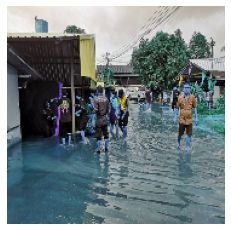

------------------------------------------------------
The prediction class of image is: flood
The real class of image is: garbage
flood : 50.6387 %
garbage : 35.051 %
pavement : 0.7323 %
safety : 8.4354 %
traffic : 5.1425 %


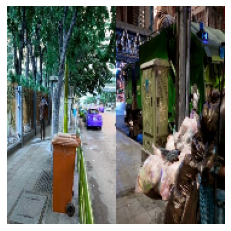

------------------------------------------------------
The prediction class of image is: garbage
The real class of image is: traffic
flood : 9.561 %
garbage : 77.4474 %
pavement : 4.2494 %
safety : 7.076 %
traffic : 1.6662 %


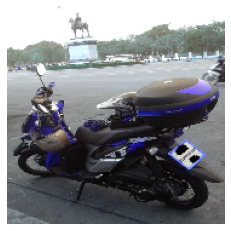

------------------------------------------------------


In [90]:
#แสดงตัวอย่างของผลการทำนาย test ของ test index ที่ 0,21,81

classification = ['flood','garbage','pavement','safety','traffic']
list_index = [0,1,2,3,4]
index_img = [0,21,81]


for j in index_img:
    pred_mb = model_mobile.predict(X_test_mb)
    print('The prediction class of image is:', classification[np.argmax(pred_mb[j])])
    print('The real class of image is:', classification[y_test_mb[j]])
    for i in range(5):       
        print(classification[list_index[i]], ':', round(pred_mb[j][list_index[i]]*100,4),'%') 
    plt.axis('off')
    plt.imshow(X_test[j])
    plt.show() 
    print('------------------------------------------------------')

### 8) Random Forest
ในหัวข้อนี้จะแบ่งออกเป็น 2 หัวข้อใหญ่ ดังนี้
- เตรียมข้อมูลก่อนเข้าโมเดล Random Forest
- โมเดล Random Forest

8.1) เตรียมข้อมูลก่อนเข้าโมเดล Random Forest

    8.1.1) ทำการ reshape ข้อมูลก่อนนำไป train

In [128]:
#ทำการ reshape ข้อมูล train ให้อยู่ในรูป 2 มิติ
nsamples, nx, ny, nrgb = X_train_scaled.shape
x_train2 = X_train_scaled.reshape((nsamples,nx*ny*nrgb))
x_train2.shape

(400, 97200)

In [129]:
#ทำการ reshape ข้อมูล test ให้อยู่ในรูป 2 มิติ
nsamples, nx, ny, nrgb = X_test_scaled.shape
x_test2 = X_test_scaled.reshape((nsamples,nx*ny*nrgb))
x_test2.shape

(100, 97200)

8.2) โมเดล Random Forest

    8.2.1) ทำการ train โมเดล Random Forest

In [119]:
#มีการ train โมเดลโดยกำหนด hyperparameter ต่าง ๆ 
rf = RandomForestClassifier(n_estimators = 300, max_depth = 100, min_samples_split = 4
                            , min_samples_leaf = 10, random_state = 42)
rf.fit(x_train2,y_train)

RandomForestClassifier(max_depth=100, min_samples_leaf=10, min_samples_split=4,
                       n_estimators=300, random_state=42)

    8.2.2) ทำการ Evaluate โมเดลและทดสอบการทำนายข้อมูล test ด้วยโมเดล Random Forest

In [120]:
#แสดงค่า prediction ที่ได้จากการทำนายข้อมูล test
y_pred_rf = rf.predict(x_test2)
y_pred_rf

array([0, 0, 0, 0, 2, 2, 4, 0, 2, 4, 2, 0, 4, 1, 0, 2, 0, 1, 1, 0, 1, 3,
       2, 1, 3, 1, 2, 4, 1, 1, 4, 1, 0, 2, 1, 1, 1, 1, 1, 3, 4, 2, 0, 3,
       2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 3, 0, 4, 4, 4, 3,
       3, 1, 4, 4, 3, 1, 4, 1, 4, 3, 2, 4, 4, 0, 0, 4, 0, 2, 0, 3, 3, 1,
       4, 4, 0, 2, 0, 4, 1, 4, 4, 3, 4, 0])

In [121]:
#ดูค่า metric ต่าง ๆ ในแต่ละ class
accuracy_score(y_pred_rf,y_test)
print(classification_report(y_pred_rf,y_test))

              precision    recall  f1-score   support

           0       0.45      0.43      0.44        21
           1       0.55      0.48      0.51        23
           2       0.55      0.50      0.52        22
           3       0.25      0.42      0.31        12
           4       0.35      0.32      0.33        22

    accuracy                           0.43       100
   macro avg       0.43      0.43      0.42       100
weighted avg       0.45      0.43      0.44       100



The prediction class of image is: flood
The real class of image is: flood


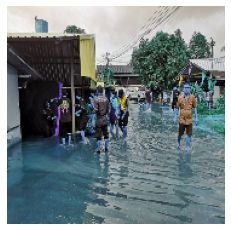

The prediction class of image is: safety
The real class of image is: garbage


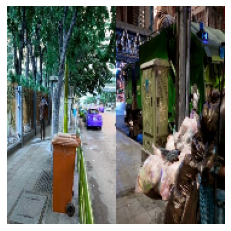

The prediction class of image is: traffic
The real class of image is: traffic


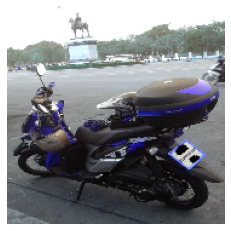

In [122]:
#แสดงตัวอย่างของผลการทำนาย test ของ test index ที่ 0,21,81
classification = ['flood','garbage','pavement','safety','traffic']
list_index = [0,1,2,3,4]
index_img = [0,21,81]

for j in index_img:
    print('The prediction class of image is:', classification[(y_pred_rf[j])])
    print('The real class of image is:', classification[y_test[j]])
 
    plt.axis('off')
    plt.imshow(X_test[j])
    plt.show() 

### 9) การ save model เพื่อนำไปใช้ในการ deployed